In [1]:
import cartopy.crs as ccrs
import cosima_cookbook as cc
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import cmocean as cm
from dask.distributed import Client
import matplotlib.path as mpath
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr

# Avoid the Runtime errors in true_divide encountered when trying to divide by zero
import warnings
warnings.filterwarnings('ignore', category = RuntimeWarning)
warnings.filterwarnings('ignore', category = ResourceWarning)
warnings.filterwarnings('ignore', category = BytesWarning)

# matplotlib stuff:
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib
from mpl_toolkits.mplot3d import axes3d
%matplotlib inline
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'
matplotlib.rcParams['lines.linewidth'] = 2.0

In [2]:
import logging
logger = logging.getLogger("distributed.utils_perf")
logger.setLevel(logging.ERROR)

In [3]:
from dask.distributed import Client
client = Client()
client

Client Scheduler: tcp://127.0.0.1:36071 Dashboard: /proxy/8787/status,Cluster Workers: 4 Cores: 16 Memory: 64.00 GiB


In [4]:
db = '/g/data/x77/db6174/access-om2/archive/databases/cc_database_nostress_paramKPP.db'
session_pram = cc.database.create_session(db)

db = '/scratch/x77/db6174/access-om2/archive/databases/cc_database_nostress_total.db'
session_Ryan = cc.database.create_session(db)

expt = ['025deg_jra55_ryf_nostress_cont', '025deg_jra55_ryf_nostress', '025deg_jra55_ryf_param_kpp3', '025deg_jra55_ryf_nostress_param_kpp']
session = [session_Ryan, session_Ryan, session_pram, session_pram]
name = ['Control_Ryan', 'Nostress_Ryan', 'Control_pram', 'Nostress_pram']

In [5]:
start_time = '1900-01-01'
end_time = '1955-12-31'

ncoarse = 12

x_min = [-100, -250, -70, -250]
x_max = [ 10 , -100,  20, -80 ]
y_min = [ 20 ,  20 , -80, -80 ]
y_max = [ 75 ,  75 , -55, -55 ]
basin = ['NA', 'NP', 'SA', 'SP']

## Time series of hblt depths

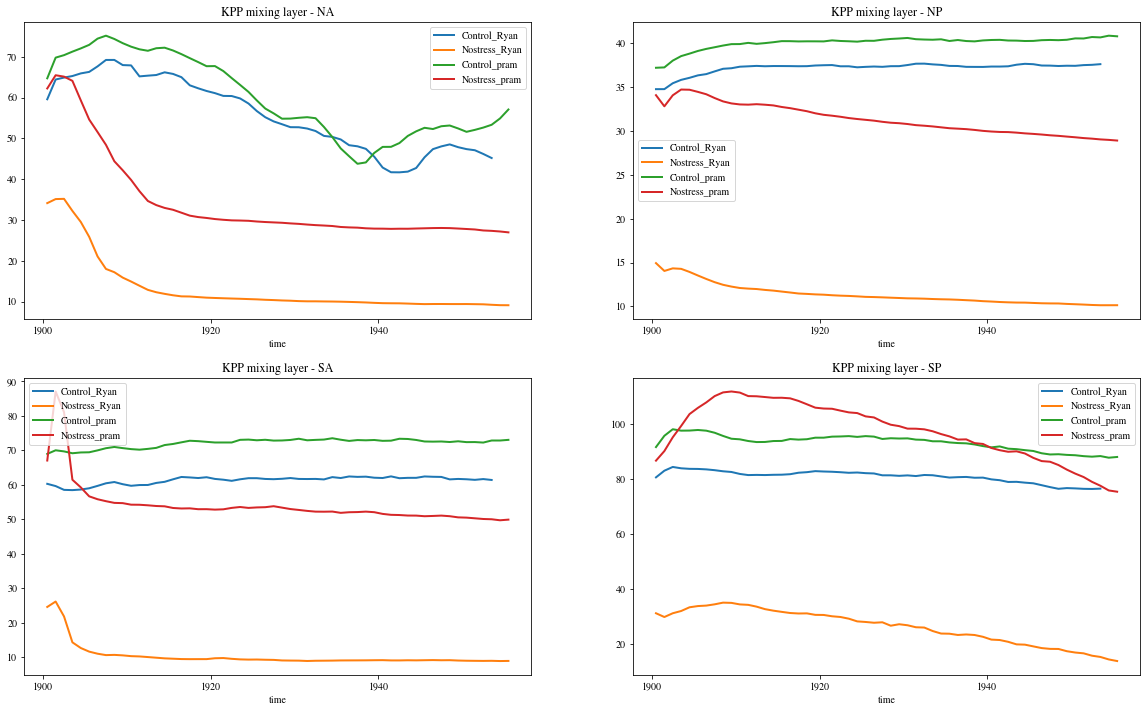

In [11]:
fig, axes = plt.subplots(nrows = 2, ncols = 2, figsize = (20, 12))

for i, j in enumerate(session):
    
    hblt = cc.querying.getvar(expt = expt[i], session = j, variable = 'hblt', frequency = '1 monthly').sel(time = slice(start_time, end_time))
    finite_variable = xr.ufuncs.isfinite(hblt)
    
    for k, l in enumerate(basin):
        
        area_t = cc.querying.getvar(expt = expt[i], variable = 'area_t', session = j, frequency = 'static', n = 1)
        area_t = area_t.sel(xt_ocean = slice(x_min[k], x_max[k])).sel(yt_ocean = slice(y_min[k], y_max[k]))
        area_t_basin = (finite_variable * area_t).mean('time')
        
        hblt_basin = (hblt*area_t_basin).sum(dim = ['yt_ocean','xt_ocean'])/area_t_basin.sum(dim = ['yt_ocean','xt_ocean'])
        hblt_basin = hblt_basin.coarsen({"time": ncoarse}, boundary = "trim").mean()
        hblt_basin.sel(time = slice(start_time, end_time)).plot(ax = axes[int(k/2)][int(k%2)],label = name[i])
        del area_t
        
        axes[int(k/2)][int(k%2)].legend()
        axes[int(k/2)][int(k%2)].set_title('KPP mixing layer - ' + basin[k])

## Time series of surface heat flux for different basins

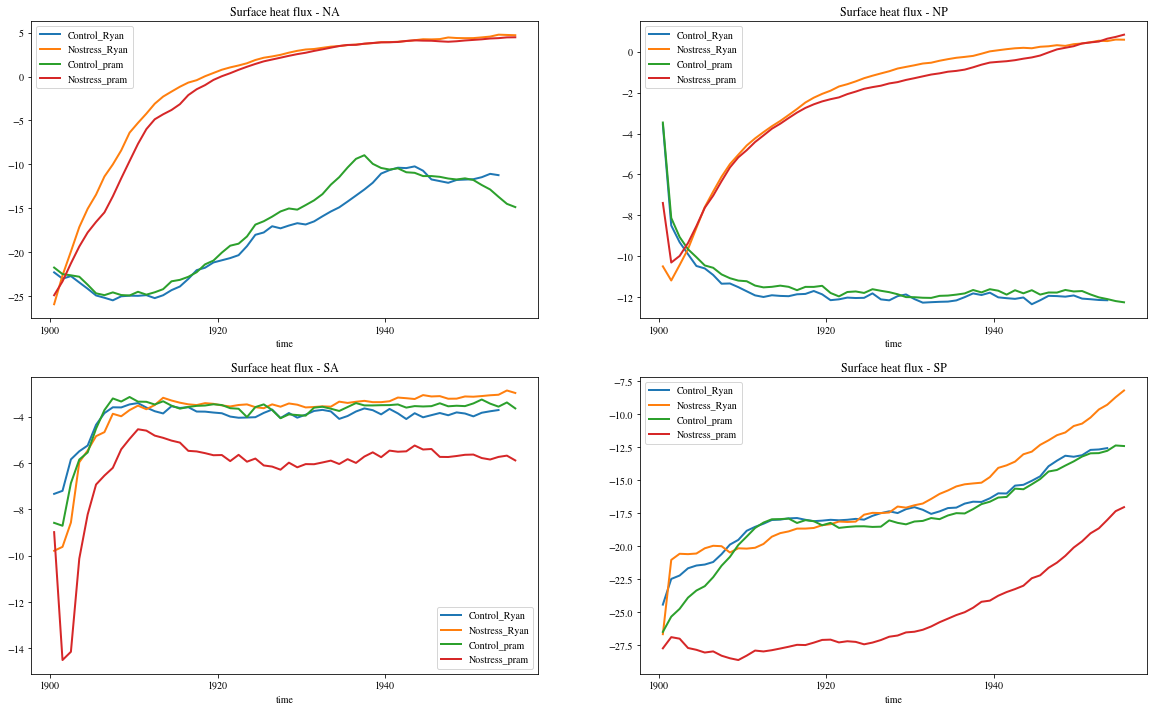

In [6]:
fig, axes = plt.subplots(nrows = 2, ncols = 2, figsize = (20, 12))

for i, j in enumerate(session):
    
    hflux = cc.querying.getvar(expt = expt[i], session = j, variable = 'net_sfc_heating', frequency = '1 monthly').sel(time = slice(start_time, end_time))
    finite_variable = xr.ufuncs.isfinite(hflux)
    
    for k, l in enumerate(basin):
        
        area_t = cc.querying.getvar(expt = expt[i], variable = 'area_t', session = j, frequency = 'static', n = 1)
        area_t = area_t.sel(xt_ocean = slice(x_min[k], x_max[k])).sel(yt_ocean = slice(y_min[k], y_max[k]))
        area_t_basin = (finite_variable * area_t).mean('time')
        
        hflux_basin = (hflux*area_t_basin).sum(dim = ['yt_ocean','xt_ocean'])/area_t_basin.sum(dim = ['yt_ocean','xt_ocean'])
        hflux_basin = hflux_basin.coarsen({"time": ncoarse}, boundary = "trim").mean()
        hflux_basin.sel(time = slice(start_time, end_time)).plot(ax = axes[int(k/2)][int(k%2)],label = name[i])
        del area_t
        
        axes[int(k/2)][int(k%2)].legend()
        axes[int(k/2)][int(k%2)].set_title('Surface heat flux - ' + basin[k])

## Maps of surface heat flux for different basins

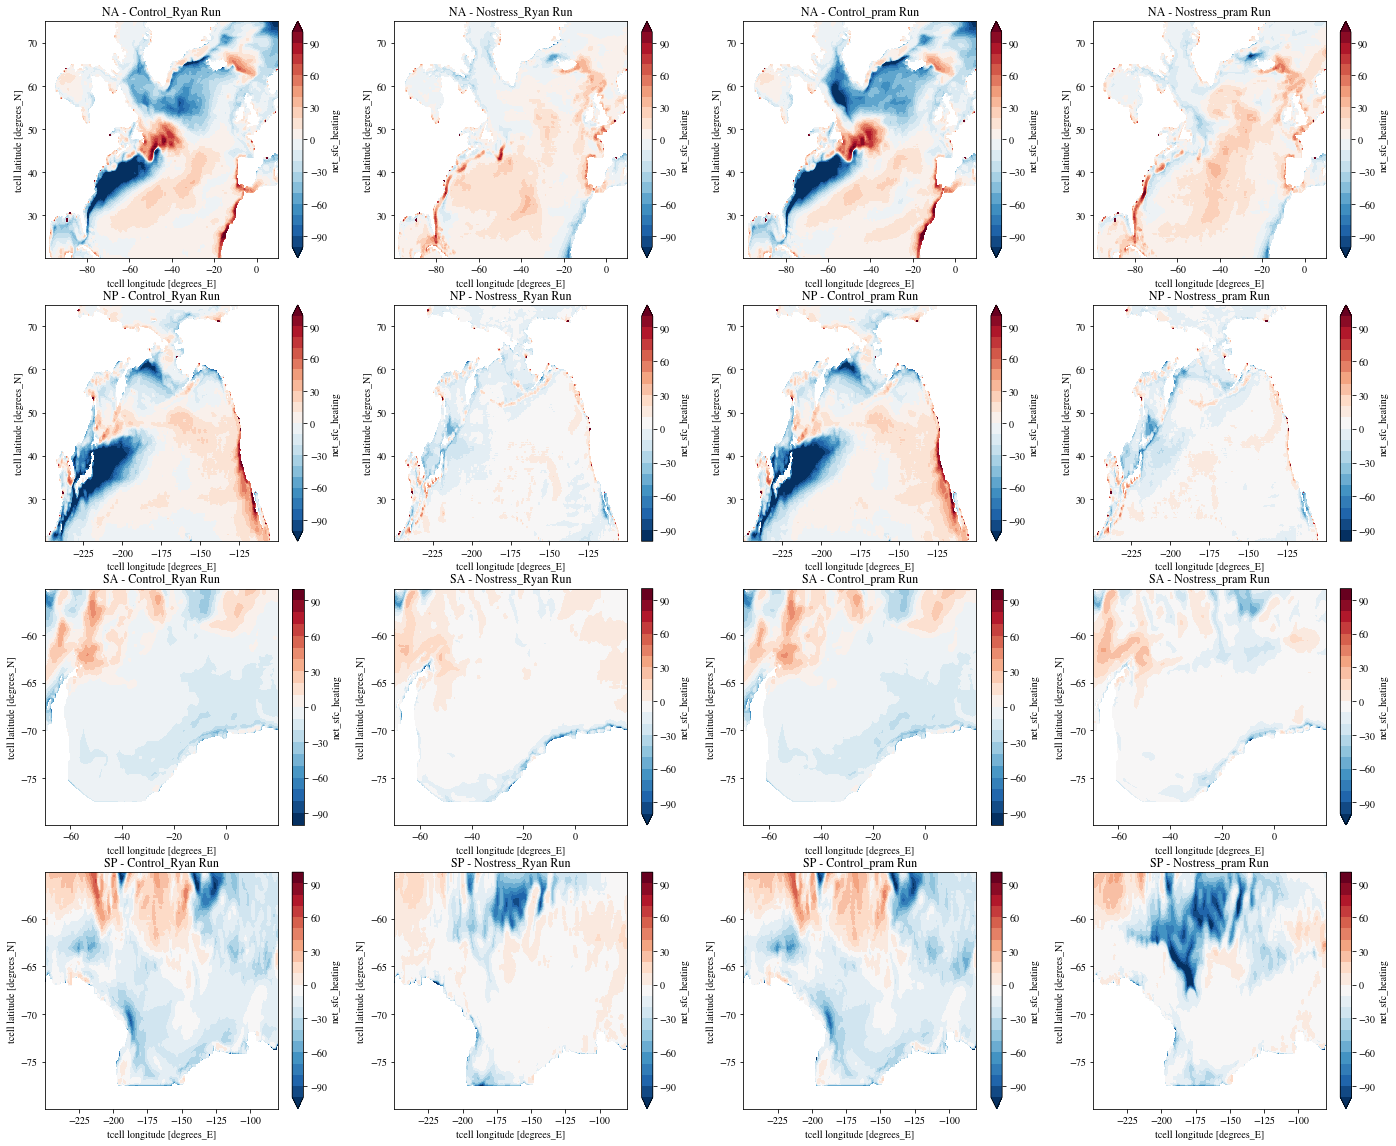

In [24]:
start_time_heat = '1945-01-01'
end_time_heat = '1955-12-31'

fig, axes = plt.subplots(nrows = 4, ncols = 4, figsize = (24, 20))

for i, j in enumerate(session):
    sfc_heat = cc.querying.getvar(expt = expt[i], session = j, variable = 'net_sfc_heating', frequency = '1 monthly').sel(time = slice(start_time, end_time))
        
    for k, l in enumerate(basin):
        sfc_heat_basin = sfc_heat.sel(xt_ocean = slice(x_min[k], x_max[k])).sel(yt_ocean = slice(y_min[k], y_max[k]))    
        sfc_heat_basin.sel(time = slice(start_time_heat, end_time_heat)).mean('time').plot.contourf(ax = axes[k][i], levels = np.linspace(-100, 100, 21))
        axes[k][i].set_title(str(basin[k]) + ' - ' + name[i] + ' Run')

## Individual contributions: Time series

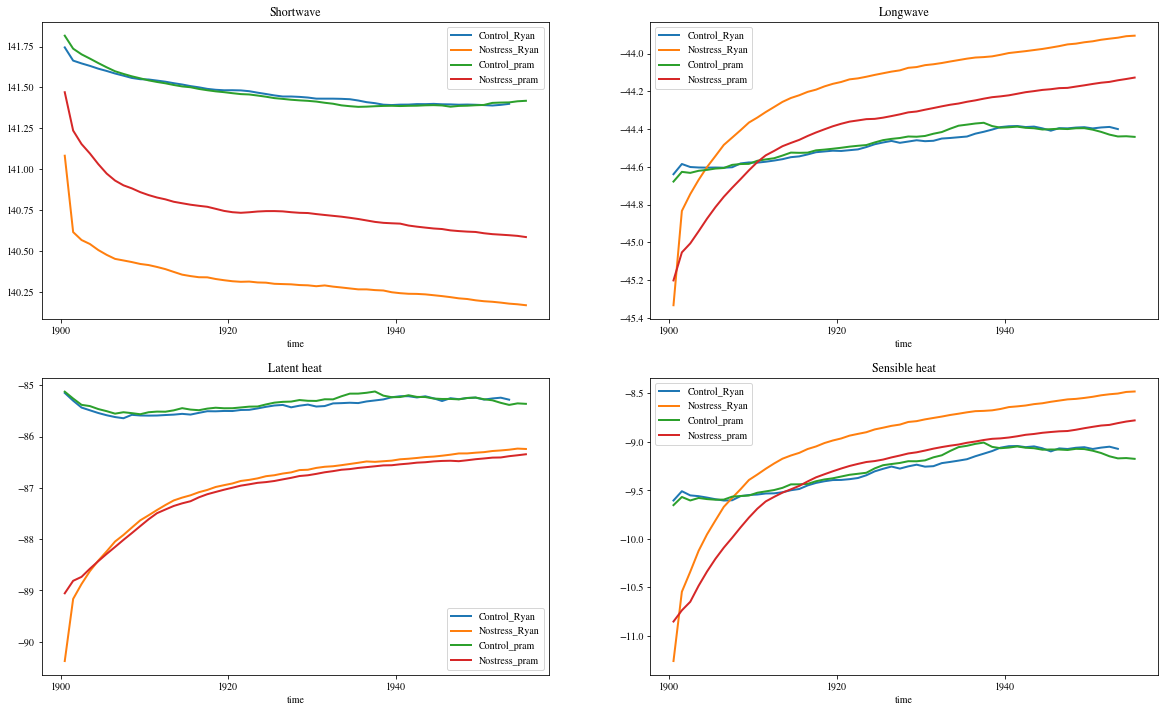

In [8]:
fig, axes = plt.subplots(nrows = 2, ncols = 2, figsize = (20, 12))

var_list = ['swflx', 'lw_heat', 'evap_heat', 'sens_heat']
var_name = ['Shortwave', 'Longwave', 'Latent heat', 'Sensible heat']

area_t = cc.querying.getvar(expt = expt[0], variable = 'area_t', session = session[0], frequency = 'static', n = 1)

for k, l in enumerate(var_list):
    for i, j in enumerate(session):
        variable = cc.querying.getvar(expt = expt[i], session = j, variable = l, frequency = '1 monthly').sel(time = slice(start_time, end_time))
        variable = (variable * area_t).sum(dim = ['yt_ocean','xt_ocean'])/area_t.sum(dim = ['yt_ocean','xt_ocean'])
        variable = variable.coarsen({"time": ncoarse}, boundary = "trim").mean()
        variable.sel(time = slice(start_time, end_time)).plot(ax = axes[int(k/2)][int(k%2)], label = name[i])
        axes[int(k/2)][int(k%2)].legend()
        axes[int(k/2)][int(k%2)].set_title(var_name[k])

## Total heat fluxes: Zonally averaged

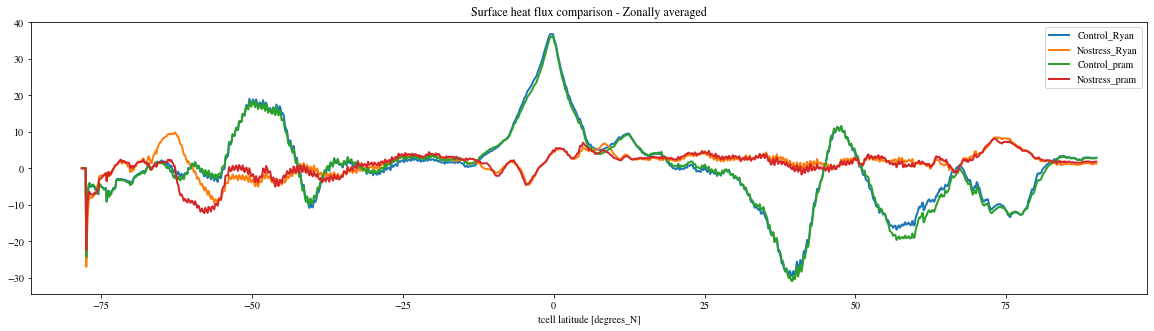

In [9]:
plt.figure(figsize = (20, 5))

start_time_heat = '1945-01-01'
end_time_heat = '1955-12-31'

for i, j in enumerate(session):
    sum_var = 0
    for k, l in enumerate(var_list):
        variable = cc.querying.getvar(expt = expt[i], session = j, variable = l, frequency = '1 monthly').sel(time = slice(start_time_heat, end_time_heat))
        variable = (variable * area_t).sum(dim = ['xt_ocean'])/area_t.sum(dim = ['xt_ocean'])
        variable = variable.coarsen({"time": ncoarse}, boundary = "trim").mean()
        sum_var = sum_var + variable
    sum_var.sel(time = slice(start_time_heat, end_time_heat)).mean('time').plot(label = name[i])
    plt.legend()
    plt.title('Surface heat flux comparison - Zonally averaged')

## Individual contributions: Zonally averaged

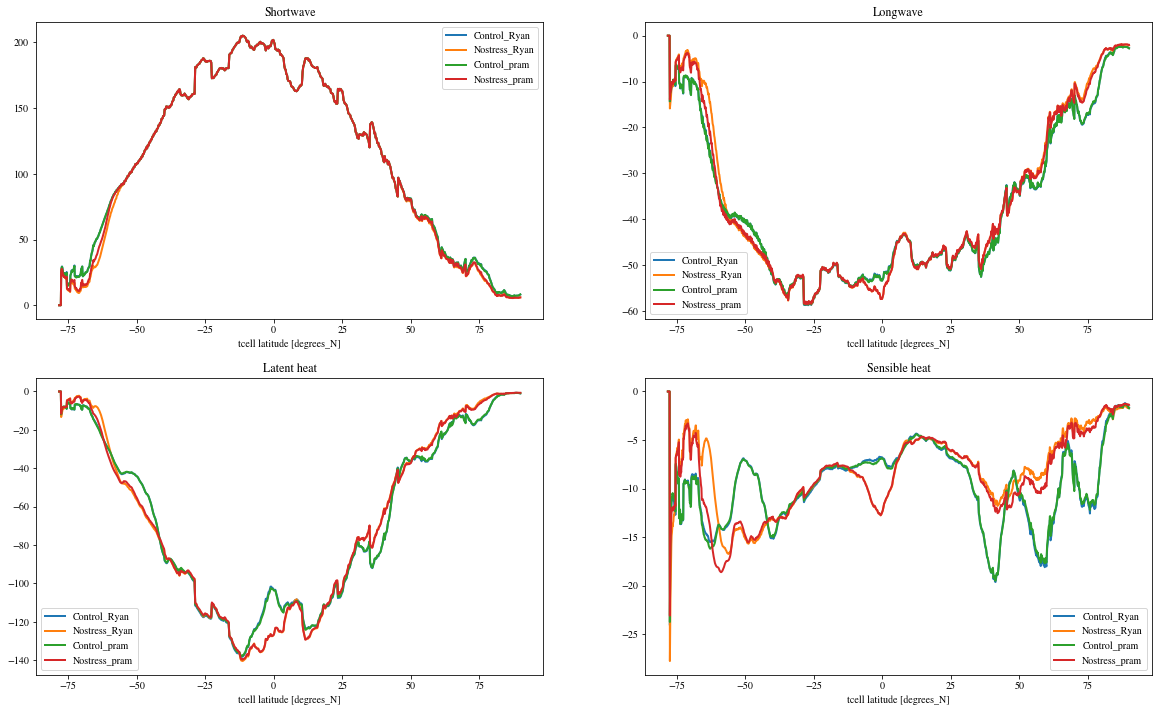

In [10]:
fig, axes = plt.subplots(nrows = 2, ncols = 2, figsize = (20, 12))

for k, l in enumerate(var_list):
    for i, j in enumerate(session):
        variable = cc.querying.getvar(expt = expt[i], session = j, variable = l, frequency = '1 monthly').sel(time = slice(start_time, end_time))
        variable = (variable * area_t).sum(dim = ['xt_ocean'])/area_t.sum(dim = ['xt_ocean'])
        variable = variable.coarsen({"time": ncoarse}, boundary = "trim").mean()
        variable.sel(time = slice(start_time, end_time)).mean('time').plot(ax = axes[int(k/2)][int(k%2)], label = name[i])
        axes[int(k/2)][int(k%2)].legend()
        axes[int(k/2)][int(k%2)].set_title(var_name[k])

## Gyre response

In [6]:
rho0 = 1025
start_time_gyre = '1945-01-01'
end_time_gyre = '1955-12-31'

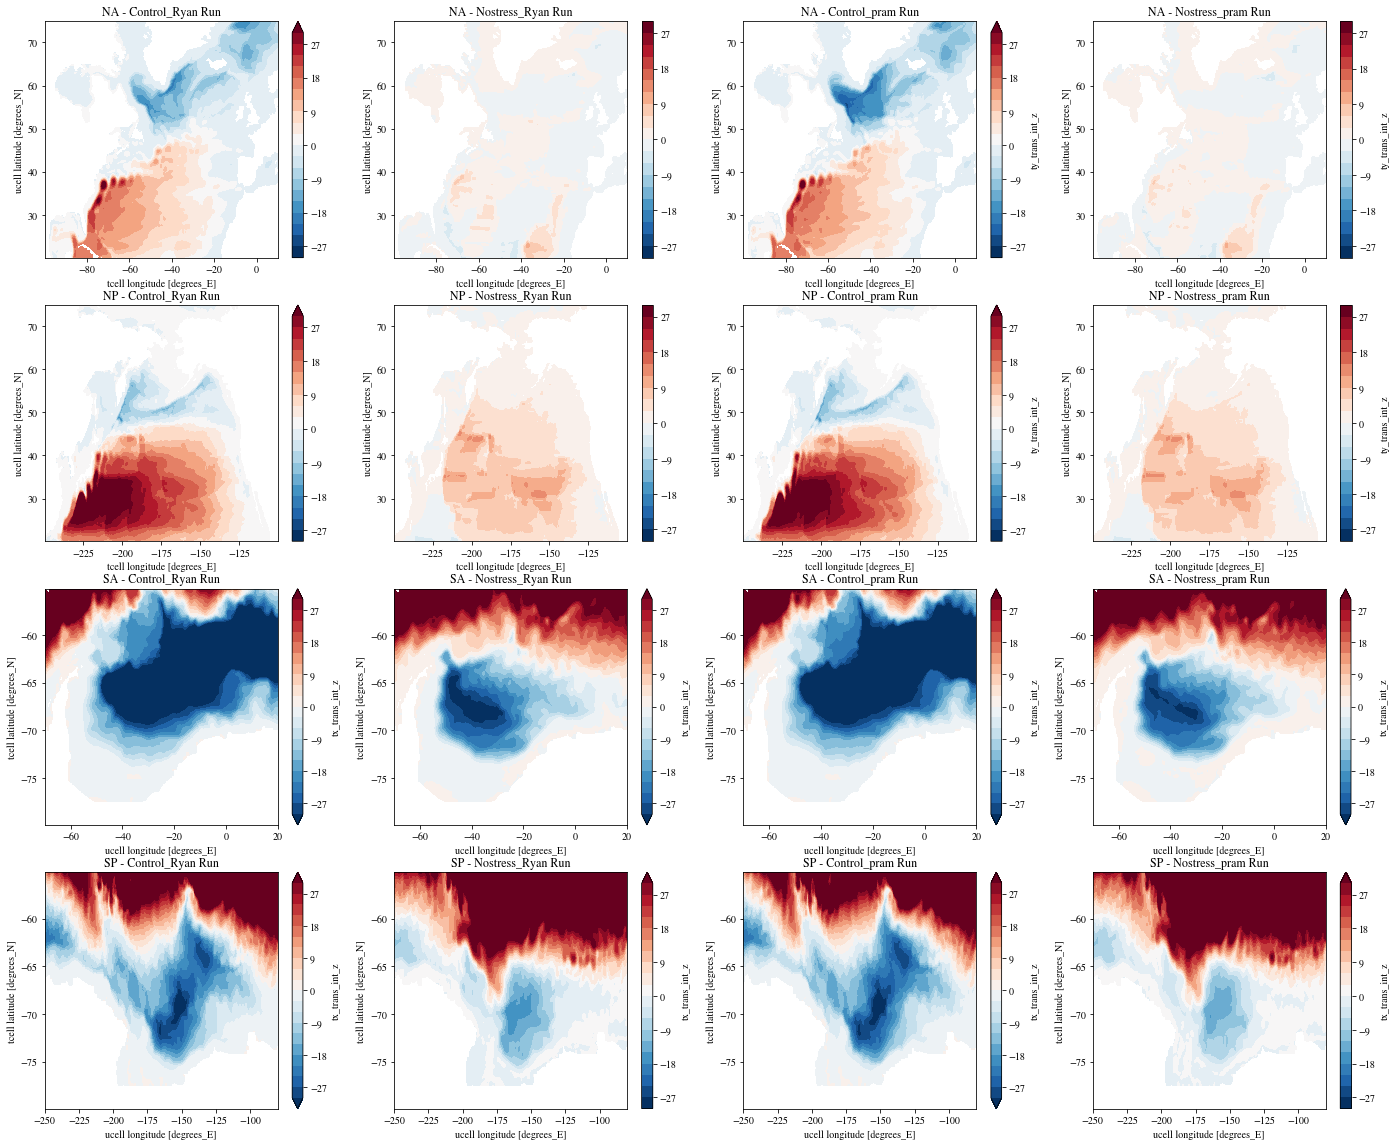

In [23]:
fig, axes = plt.subplots(nrows = 4, ncols = 4, figsize = (24, 20))

for i, j in enumerate(session):
    tx_trans = cc.querying.getvar(expt = expt[i], session = j, variable = 'tx_trans_int_z', frequency = '1 monthly').sel(time = slice(start_time_gyre, end_time_gyre))
    ty_trans = cc.querying.getvar(expt = expt[i], session = j, variable = 'ty_trans_int_z', frequency = '1 monthly').sel(time = slice(start_time_gyre, end_time_gyre))
    
    # Problem with Ryan's experiments. Ideally, we should use ty_trans from above only
    if(i == 0 or i == 1):
        temp1 = ty_trans.values - tx_trans.values
        ty_trans = xr.DataArray(temp1, coords = [tx_trans.time, ty_trans.yu_ocean, ty_trans.xt_ocean], dims = ['time', 'yu_ocean', 'xt_ocean'])
    
    for k, l in enumerate(basin):
        if(l == 'NA' or l == 'NP'):
            ty_basin = ty_trans.sel(xt_ocean = slice(x_min[k], x_max[k])).sel(yu_ocean = slice(y_min[k], y_max[k]))
            psi_basin = ty_basin.cumsum('xt_ocean').where(abs(ty_basin<=1.e20))/(rho0*1.e6)
        else:
            tx_basin = tx_trans.sel(xu_ocean = slice(x_min[k], x_max[k])).sel(yt_ocean = slice(y_min[k], y_max[k]))
            psi_basin = tx_basin.cumsum('yt_ocean').where(abs(tx_basin<=1.e20))/(rho0*1.e6)
            
        psi_basin.sel(time = slice(start_time, end_time)).mean('time').plot.contourf(ax = axes[k][i], levels = np.linspace(-30, 30, 21))
        axes[k][i].set_title(str(basin[k]) + ' - ' + name[i] + ' Run')

## Overturning response

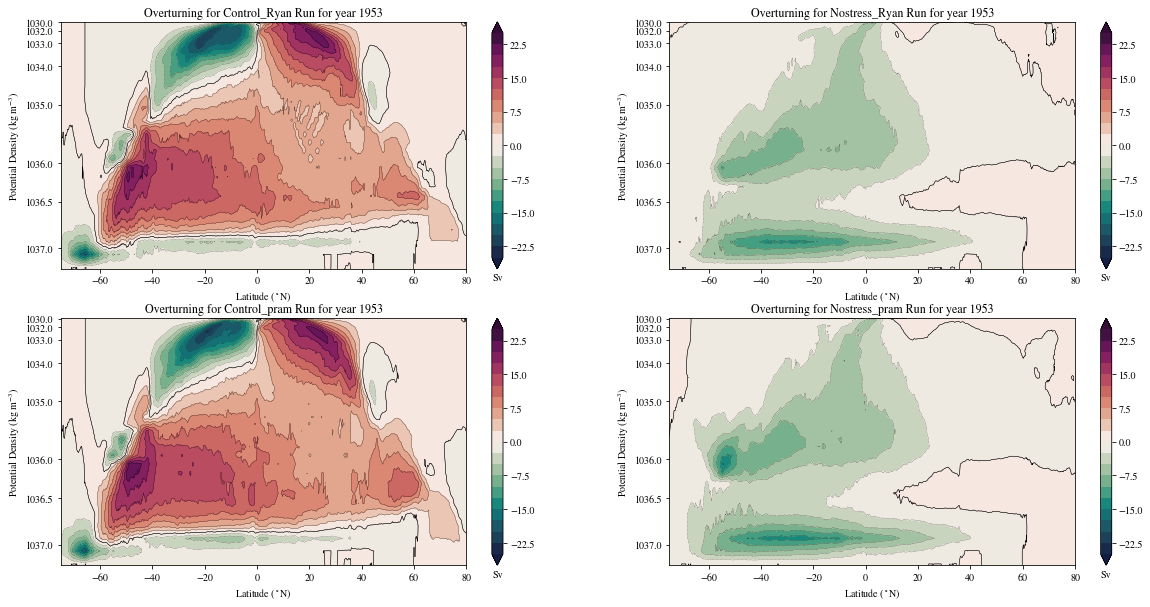

In [22]:
fig, ax = plt.subplots(nrows = 2, ncols = 2, figsize = (20, 10)) 
#clev = np.arange(-25, 27, 2)
clev = np.linspace(-25, 25, 21)
yticks = np.array([1030, 1032, 1033, 1034, 1035, 1036,1036.5, 1037])
scfac = 4  ## A power to set teh stretching
start_time_OC = '1953-01-01'
end_time_OC = '1953-12-31'
rho = 1025 # mean density of sea-water in kg/m^3

for i, j in enumerate(session):
    
    #psiGM = cc.querying.getvar(expt[i], 'ty_trans_rho_gm', session = j, start_time = start_time_OC, end_time = end_time_OC)
    #psiGM = psiGM.sum('grid_xt_ocean')
    #psiGM = psiGM / (1e6*rho)
    
    psi = cc.querying.getvar(expt[i], 'ty_trans_rho', session = j, start_time = start_time_OC, end_time = end_time_OC)
    psi = psi.sum('grid_xt_ocean').sel(time = slice(start_time_OC, end_time_OC))
    psi = psi / (1e6*rho) # converts kg/s to Sv
    psi_avg = psi.cumsum('potrho').mean('time') - psi.sum('potrho').mean('time')
    
    psi_avg = psi_avg #+ psiGM.mean('time')

    p1 = ax[int(i/2)][int(i%2)].contourf(psi_avg.grid_yu_ocean,(psi_avg.potrho-1028)**scfac, psi_avg, cmap=cm.cm.curl, levels = clev, extend = 'both')
    cb = plt.colorbar(p1, orientation = 'vertical', ax = ax[int(i/2)][int(i%2)])
    cb.ax.set_xlabel('Sv')
    ax[int(i/2)][int(i%2)].contour(psi_avg.grid_yu_ocean,(psi_avg.potrho - 1028)**scfac, psi_avg, levels = clev, colors = 'k', linewidths = 0.25)
    ax[int(i/2)][int(i%2)].contour(psi_avg.grid_yu_ocean,(psi_avg.potrho - 1028)**scfac, psi_avg, levels = [0.0,], colors = 'k', linewidths = 0.5)

    ax[int(i/2)][int(i%2)].set_yticks((yticks-1028)**scfac)
    ax[int(i/2)][int(i%2)].set_yticklabels(yticks)
    ax[int(i/2)][int(i%2)].set_ylim([0.5**scfac, 9.2**scfac])
    ax[int(i/2)][int(i%2)].invert_yaxis()
    ax[int(i/2)][int(i%2)].set_ylabel('Potential Density (kg m$^{-3}$)')
    ax[int(i/2)][int(i%2)].set_xlabel('Latitude ($^\circ$N)')
    ax[int(i/2)][int(i%2)].set_xlim([-75,80])
    ax[int(i/2)][int(i%2)].set_title('Overturning for ' + str(name[i]) + ' Run for year 1953');